In [2]:
from PIL import Image
import numpy as np
import os
import shutil
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import imageio
import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import cv2

from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D # to add convolutional layers
from keras.layers.convolutional import MaxPooling2D # to add pooling layers

Using TensorFlow backend.


In [2]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['val_loss'][-1]
    acc = history.history['val_acc'][-1]
    plt.title('Validation Loss: %.3f, Validation Accuracy: %.3f' % (loss, acc))

In [3]:
train_categories = pd.read_csv('train.csv')
train_images = train_categories.image_names.values.tolist()
location = 'C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\janata-hack_computer_vision_hackathon\\vehicles'
trainLabels = {}
f = open("train.csv", "r")
vehicles = f.read()
vehicles = vehicles.split('\n')
for i in range(len(vehicles) - 1):
    vehicles[i] = vehicles[i].split(',')
    trainLabels[vehicles[i][0].split('.')[0]] = vehicles[i][1]
del trainLabels['image_names']

test_images = pd.read_csv('test.csv')
testImages = test_images.image_names.values.tolist()

In [4]:
Vehicles = trainLabels.values()
trainSet = set(Vehicles)
itr_set = {}
for i in trainSet:
    itr_set[i] = 0

In [5]:
if not os.path.exists(location + str('\\train_labelled')):
    os.makedirs(location + str('\\train_labelled'))
    for img in tqdm(os.listdir(location)):
        if not img in train_images:
            continue
        imgName = img.split('.')[0]
        label = trainLabels[str(imgName)]
        itr_set[label] += 1
        path = os.path.join(location + '\\', img)
        saveName = location + '\\train_labelled\\' + label + '-' + str(itr_set[label]) + '.jpg'
        image_data = np.array(Image.open(path))
        imageio.imwrite(saveName, image_data)

if not os.path.exists(location + str('\\test_images')):
    os.makedirs(location + str('\\test_images'))
    for image in testImages:
        shutil.move(location + '\\' + str(image), location + str('\\test_images'))

In [6]:
def label_img(name):
    word_label = name.split('-')[0]
    if word_label == '0' : return np.array([1, 0]) # Not Emergency
    elif word_label == '1' : return np.array([0, 1]) # Emergency

In [7]:
def get_size_statistics(DIR):
    heights = []
    widths = []
    for img in tqdm(os.listdir(DIR)): 
        path = os.path.join(DIR, img)
        data = np.array(Image.open(path)) #PIL Image library
        heights.append(data.shape[0])
        widths.append(data.shape[1])
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

In [8]:
get_size_statistics(location + '\\train_labelled')


Average Height: 224.0
Max Height: 224
Min Height: 224
Average Width: 224.0
Max Width: 224
Min Width: 224


In [9]:
IMG_SIZE = 300
def load_training_data(DIR):
    train_data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), label])
    shuffle(train_data)
    return train_data

def load_validation_data(DIR):
    val_data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        val_data.append([np.array(img), label])
    shuffle(val_data)
    return val_data

def load_testing_data(DIR):
    test_data = []
    for Img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, Img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([np.array(img), Img])
    return test_data

In [10]:
"""
IMG_SIZE = 224
def load_training_data(DIR):
    train_data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        train_data.append([np.array(img), label])
        # Basic Data Augmentation - Horizontal Flipping
        flip_img = Image.open(path)
        flip_img = flip_img.convert('L')
        flip_img = flip_img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        flip_img = np.array(flip_img)
        flip_img = np.fliplr(flip_img)
        train_data.append([flip_img, label])
    shuffle(train_data)
    return train_data
"""

"\nIMG_SIZE = 224\ndef load_training_data(DIR):\n    train_data = []\n    for img in tqdm(os.listdir(DIR)):\n        label = label_img(img)\n        path = os.path.join(DIR, img)\n        img = Image.open(path)\n        img = img.convert('L')\n        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)\n        train_data.append([np.array(img), label])\n        # Basic Data Augmentation - Horizontal Flipping\n        flip_img = Image.open(path)\n        flip_img = flip_img.convert('L')\n        flip_img = flip_img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)\n        flip_img = np.array(flip_img)\n        flip_img = np.fliplr(flip_img)\n        train_data.append([flip_img, label])\n    shuffle(train_data)\n    return train_data\n"

In [11]:
train_data = load_training_data(location + '\\train_labelled')
val_data = load_validation_data(location + '\\test_labelled')
X_train = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_train = X_train / 255 # normalize training data
y_train = np.array([i[1] for i in train_data])
y_train = y_train / 255 # normalize training data
X_test = np.array([i[0] for i in val_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test / 255 # normalize test data
y_test = np.array([i[1] for i in val_data])
y_test = y_test / 255 # normalize training data

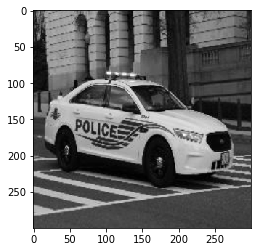

In [12]:
plt.imshow(train_data[1247][0], cmap = 'gist_gray')

In [13]:
def convolutional_model():
    ADAMAX = optimizers.Adamax(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    ADAM = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer = l2(0.0005), bias_regularizer = l2(0.0005)))
    model.add(Dense(2, activation = 'softmax'))
    # Compile model
    model.compile(optimizer = ADAMAX, loss = 'categorical_crossentropy',  metrics = ['accuracy'])
    return model

In [14]:
gen = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.1, shear_range = 0.1,
                         height_shift_range = 0.1, zoom_range = 0.25, fill_mode = 'nearest', horizontal_flip = True,
                         vertical_flip = False, featurewise_center = False,
                         samplewise_center = False, featurewise_std_normalization = False,
                         samplewise_std_normalization = False)
test_gen = ImageDataGenerator()

# Create batches to  train models faster
train_generator = gen.flow(X_train, y_train, batch_size = 64)
test_generator = test_gen.flow(X_test, y_test, batch_size = 64)

In [15]:
# Use annelar to gradually decrese the learning rate to improve generalization

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 20, verbose = 1, factor = 0.4, min_lr = 0.00002,
                                            mode = 'auto', cooldown = 0)

In [ ]:
# build the model
model = convolutional_model()
epochs = 70
# fit the model

history = model.fit_generator(train_generator, steps_per_epoch = 64, epochs = epochs, 
                              validation_data = test_generator, validation_steps = 64, verbose = 0,
                              callbacks=[reduce_lr, TQDMNotebookCallback(leave_inner = True, leave_outer = True)])

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

In [ ]:
plot_loss_accuracy(history)

In [ ]:
test_data = load_testing_data(location + '\\test_images')
test = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_labels = np.array([i[1] for i in test_data])
test = test / 255 # normalize test data
Y_pred = np.round(model.predict(test))
Y_pred = np.argmax(Y_pred, axis = 1)
Y_pred = pd.Series(Y_pred, name = "Label")

In [ ]:
submission_df = pd.DataFrame({
                  "image_names": pd.Series(test_labels),
                  "emergency_or_not": pd.Series(Y_pred)})
submission_df.to_csv('submission_7.csv', index = False)

In [ ]:
LR = 0.001
model_name = 'classify_emergency_vehicles-{}-{}.model'.format(LR, '5CMB_2DO_1F_1D_conv_v3')
model.save(model_name)